# Quantum Kernel Method
---
KFUPM ICS 561 Project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix

from qiskit import BasicAer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

# Generate Data

In [77]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=35,
    test_size=15,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

# Classical Kernel Method

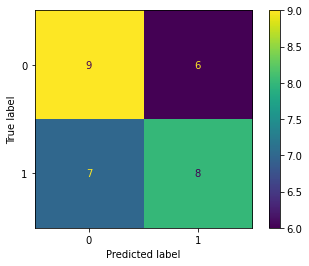

In [67]:
clf_svm = SVC()
clf_svm.fit(train_features, train_labels)
plot_confusion_matrix(clf_svm, test_features, test_labels);

## Improve 

In [68]:
param_grid = [{
    'C': [.5, 1, 10, 100],
    'gamma': ['scale', 1, .1, .01, .001, .0001],
    'kernel': ['rbf']
}]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(train_features, train_labels)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.5, 1, 10, 100],
                          'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             scoring='accuracy')

In [69]:
print(optimal_params.best_params_)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


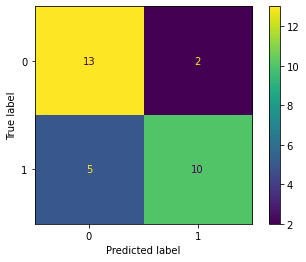

In [70]:
clf_svm = SVC(
    C=optimal_params.best_params_['C'], 
    gamma=optimal_params.best_params_['gamma'], 
    kernel=optimal_params.best_params_['kernel']
)
clf_svm.fit(train_features, train_labels)
plot_confusion_matrix(clf_svm, test_features, test_labels);

In [71]:

# fig = plt.figure(figsize=(15, 5))

# ax1 = fig.add_subplot(121)
# ax1.imshow(
#     adhoc_total,
#     interpolation="nearest",
#     origin="lower",
#     cmap="RdBu",
#     extent=[0, 2 * np.pi, 0, 2 * np.pi],
# )


# X = adhoc_total[:][0]
# Y = adhoc_total[:][0]
# Z  = np.cos(X) * np.cos(X) + np.sin(Y) * np.sin(Y)

# ax2 = fig.add_subplot(122, projection='3d')
# ax2.contourf(X, Y, adhoc_total, cmap='RdBu', zdir='z', offset=0.5,)


# plt.show()

Text(0.5, 1.0, 'Ad hoc dataset for classification')

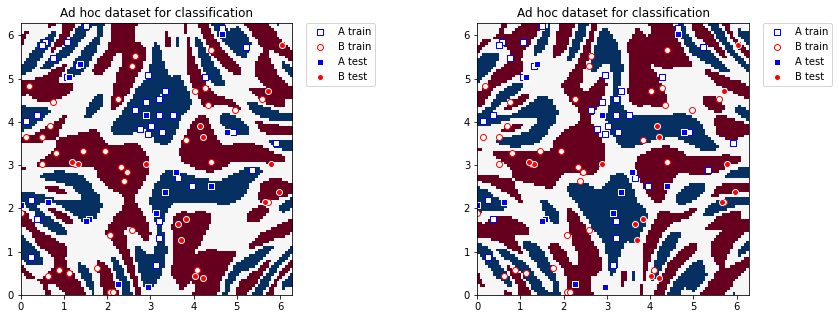

In [92]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="best", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")


plt.subplot(1, 2, 2)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
#     origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="best", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")



In [9]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

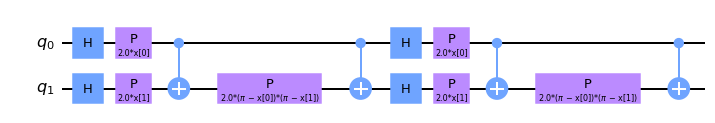

In [10]:
adhoc_feature_map.decompose().draw(output='mpl')

In [11]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_features, train_labels)
adhoc_score = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score}")

Callable kernel classification test score: 1.0


In [12]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

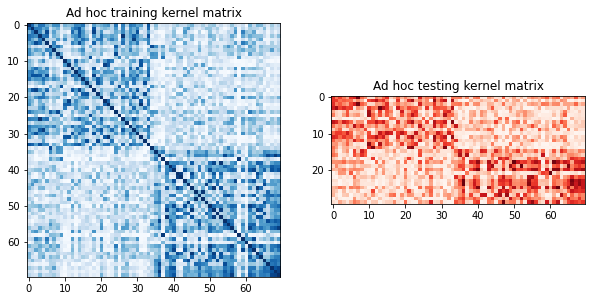

Precomputed kernel classification test score: 1.0


In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(
    np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds"
)
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score}")

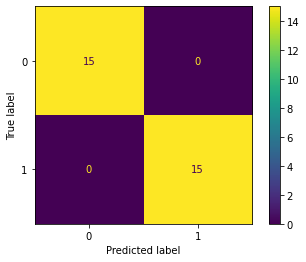

In [14]:
plot_confusion_matrix(adhoc_svc, adhoc_matrix_test, test_labels);

In [15]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


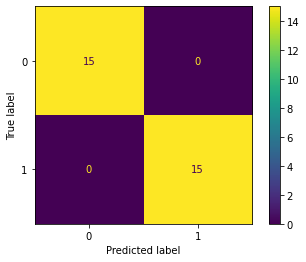

In [16]:
plot_confusion_matrix(qsvc, test_features, test_labels);

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


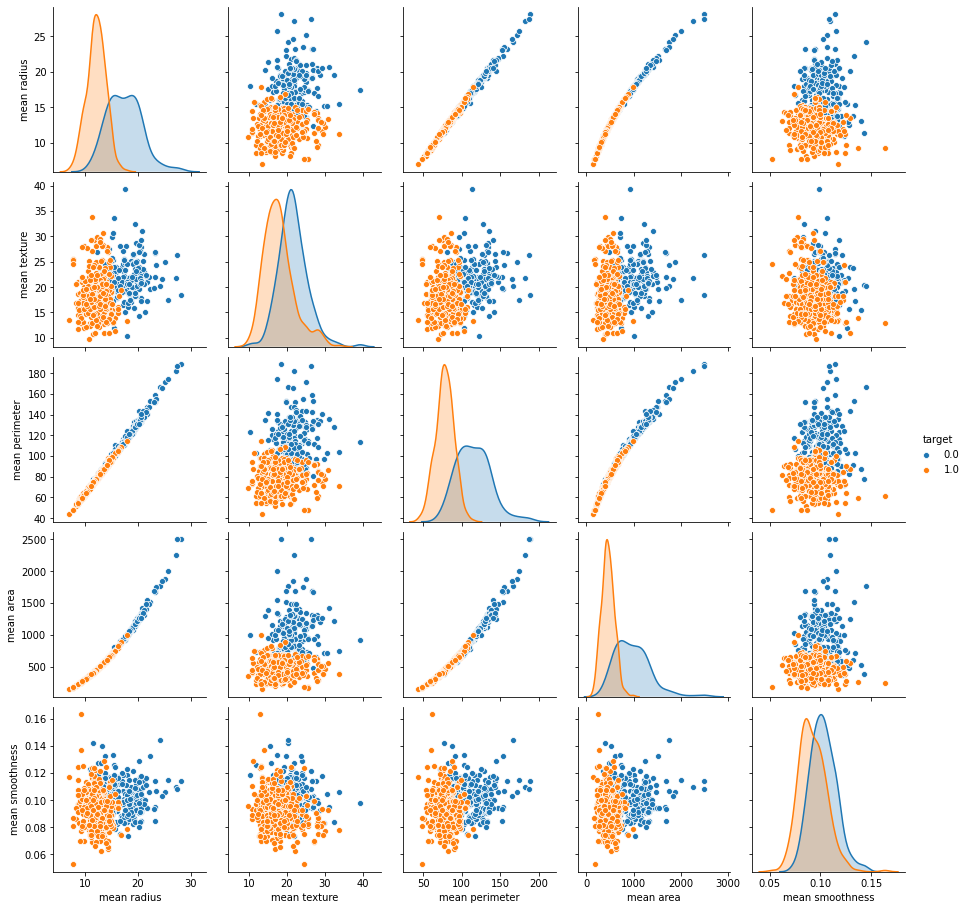

            predicted_cancer  predicted_healthy
is_cancer                 61                  5
is_healthy                 0                 48


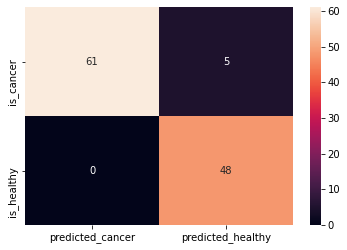

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        48
         1.0       1.00      0.92      0.96        66

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

# Dataset definition
dataset = load_breast_cancer()
df_cancer = pd.DataFrame(np.c_[dataset['data'], dataset['target']], columns=np.append(dataset['feature_names'],
                                                                                      ['target']))
sns.pairplot(df_cancer, hue='target', vars=['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                                            'mean smoothness'])
plt.show()

# Normalization
X = df_cancer.drop(['target'], axis=1)
y = df_cancer['target']

# Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

X_train_min = X_train.min()
X_train_max = X_train.max()
X_train_range = (X_train_max - X_train_min)

X_train_scaled = (X_train - X_train_min) /(X_train_range)

X_test_min = X_test.min()
X_test_range = (X_test - X_test_min).max()
X_test_scaled = (X_test - X_test_min) / X_test_range

svc_model = SVC()
svc_model.fit(X_train_scaled, y_train)
y_predict = svc_model.predict(X_test_scaled)

cm = np.array(confusion_matrix(y_test, y_predict, labels=[1, 0]))
confusion = pd.DataFrame(cm, index=['is_cancer', 'is_healthy'],
                         columns=['predicted_cancer', 'predicted_healthy'])
print(confusion)
sns.heatmap(confusion, annot=True, fmt="d")
plt.show()

print(classification_report(y_test, y_predict))


In [244]:
from qiskit_aqua.utils import split_dataset_to_data_and_labels
from qiskit_aqua.input import SVMInput
from qiskit_qcgpu_provider import QCGPUProvider
from qiskit_aqua import run_algorithm
n = 2 # How many features to use (dimensionality)
training_dataset_size = 20
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)
params = {
   'problem': {'name': 'svm_classification', 'random_seed': 10598},
   'algorithm': { 'name': 'QSVM.Kernel' },
   'backend': {'name': 'qasm_simulator', 'shots': 1024},
   'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}

backend = QCGPUProvider().get_backend('qasm_simulator')

algo_input = SVMInput(training_input, test_input, datapoints[0])
%time result = run_algorithm(params, algo_input)
%time result = run_algorithm(params, algo_input, backend=backend)

print("ground truth:    {}".format(datapoints[1]))
print("prediction:      {}".format(result['predicted_labels']))

ImportError: cannot import name 'split_dataset_to_data_and_labels' from 'qiskit.utils' (/opt/anaconda3/lib/python3.8/site-packages/qiskit/utils/__init__.py)